In [1]:
import os.path as os

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, Linear, PointNetConv, fps, global_max_pool, radius
from torch_geometric.typing import WITH_TORCH_CLUSTER

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# data set imports
import dataset_utils as du
from torch.utils.data import DataLoader, random_split

B = 1

# load dataset
dataset = du.SDFDataset("./cars100")
train_percent = 0.9


# split dataset into training and validation sets
train_size = int(train_percent * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=B, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Train dataset size: 90, Validation dataset size: 10


In [3]:
def process_batch(batch, np_in=2048, np_q=15000):
    B, N, _ = batch.shape
    assert B == 1, "Batch size must be 1 for now."
    
    # # use surface points
    # surface_points = batch[batch[:, :, 3] == 0]
    idx = torch.randperm(N)[:np_in]
    pos = batch[:, idx, :3] # input positions (B, N, 3) -> (N, 3) # this is what fps expects
    x = batch[0, idx, 3].unsqueeze(-1)
    
    idx = torch.randperm(N)[:np_q]
    query_pos = batch[:, idx, :3] # query positions
    query_sdf = batch[:, idx, 3] # SDF values
    
    batch_vec = torch.zeros(np_in, dtype=torch.long) # batch vector for input points
    
    return x.to(device), pos.contiguous().squeeze(0).to(device), batch_vec.contiguous().squeeze(0).to(device), query_pos.squeeze(0).to(device), query_sdf.squeeze(0).to(device)

Define Layers and Model

In [4]:
class SAModule(torch.nn.Module):
    def __init__(self, ratio, r, nn):
        super().__init__()
        self.ratio = ratio
        self.r = r
        self.conv = PointNetConv(nn, add_self_loops=False)

    def forward(self, x, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=128)
        edge_index = torch.stack([col, row], dim=0)
        x_dst = None if x is None else x[idx]
        x = self.conv((x, x_dst), (pos, pos[idx]), edge_index)
        pos, batch = pos[idx], batch[idx]
        return x, pos, batch


class GlobalSAModule(torch.nn.Module):
    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def forward(self, x, pos, batch):
        x = self.nn(torch.cat([x, pos], dim=1))
        x = global_max_pool(x, batch)
        pos = pos.new_zeros((x.size(0), 3))
        batch = torch.arange(x.size(0), device=batch.device)
        return x, pos, batch


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([4, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.5, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = GlobalSAModule(MLP([256 + 3, 256, 512, 1024]))

        self.encode = MLP([1024, 512], dropout=0.4, norm=None) # learn global features -> reduce to 512

        self.mlp_mu = MLP([512, 512], dropout=0.2, norm=None) # get mu
        self.mlp_logvar = MLP([512, 512], dropout=0.2, norm=None) # get logvar

        self.sdf1 = MLP([512 + 3, 256, 128], norm=None)
        self.sdf2 = MLP([128 + 3, 64, 1], norm=None)
        
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std) # std just gives dimension of tensor to give back
        return mu + epsilon * std


    def encoder(self, x, pos, batch):
        # encode shape
        sa0_out = (x, pos, batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        return sa3_out # x latent encoding from pointnet


    def vae(self, x):
        x = self.encode(x)
        mu = self.mlp_mu(x) # [1, 512]
        logvar = self.mlp_logvar(x) # [1, 512]
        z = self.reparametrize(mu, logvar) # [1, 512]
        return z, mu, logvar


    def decoder(self, x, query_pos):
        x = torch.cat((x.repeat(query_pos.shape[0], 1), query_pos), dim=-1) # concatenate encoded shape with query positions) # [B, np_q, 515]
        x = self.sdf1(x) # [B, np_q, 128]
        x = torch.cat((x, query_pos), dim=-1) # [B, np_q, 131]
        x = self.sdf2(x) # [B, np_q, 1]
        out = torch.tanh(x) # [B, np_q, 1]

        return out


    def forward(self, x, pos, batch, query_pos):
        # encode
        x, pos, batch = self.encoder(x, pos, batch)

        # vae
        x, mu, logvar = self.vae(x)
       
        # decoder
        out = self.decoder(x, query_pos)

        return out, mu, logvar

Define Loss

In [5]:
def eikonal_loss(out, query_pos):
    grads = torch.autograd.grad(out.sum(), query_pos, create_graph=True)[0]
    loss = ((grads.norm(2, dim=1) - 1).square()).mean()
    return loss

def compute_loss(out, query_pos, query_sdf, mu, logvar, w_eik=0.001, w_kl=0.001):
    loss_mse = F.mse_loss(out, query_sdf)
    loss_eik = eikonal_loss(out, query_pos)
    loss_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence loss for latent distribution

    total_loss = loss_mse + w_eik * loss_eik + w_kl * loss_kl
    #print(f'MSE Loss: {loss_mse:.4f}, Eikonal Loss: {w_eik*loss_eik:.4f}, KL Loss: {w_kl*loss_kl:.4f}') 
    
    return total_loss

def compute_loss_simple(out, query_sdf, mu, logvar):
    loss_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence loss for latent distribution
    loss_mse = F.mse_loss(out, query_sdf)

    return F.mse_loss(out, query_sdf) + 0.01*loss_kl

In [ ]:
# test model
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch = next(iter(train_loader))
print(f'Batch shape: {batch.shape}')
x, pos, batch, query_pos, query_sdf = process_batch(batch)
query_pos.requires_grad = True
print(f'pos shape: {pos.shape}, query_pos shape: {query_pos.shape}, query_sdf shape: {query_sdf.shape}, x shape: {x.shape}')

print(f'pos shape: {pos.shape}')
# forward pass
output, mu, logvar = model(x, pos, batch, query_pos)
# print output shape
print(f"Output shape: {output.shape}")

loss = compute_loss(output.squeeze(-1), query_pos, query_sdf, mu, logvar)
print(f'Loss: {loss.item()}')

Batch shape: torch.Size([1, 50000, 4])
pos shape: torch.Size([2048, 3]), query_pos shape: torch.Size([15000, 3]), query_sdf shape: torch.Size([15000]), x shape: torch.Size([2048, 1])
pos shape: torch.Size([2048, 3])
Output shape: torch.Size([15000, 1])
Loss: 0.2458796352148056


c:\Users\maxde\anaconda3\envs\final311\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


: 

In [ ]:
def show_validation():
    model.eval()
    batch = next(iter(val_loader))
    batch = batch[0,:,:].unsqueeze(0) # just take first pointcloud from batch
    
    x, pos, batch, query_pos, query_sdf = process_batch(batch)
    query_pos.requires_grad = True
    
    output, mu, logvar = model(x, pos, batch, query_pos)

    prediction = torch.cat((query_pos, output), dim=-1).detach().cpu()  # (1024, 3 + 1)
    truth = torch.cat((query_pos, query_sdf.unsqueeze(-1)), dim=-1).detach().cpu()  # (1024, 3 + 1)
    

    print("MODEL")
    du.visualize_sdf_3d(prediction.squeeze(0))
    du.visualize_sdf_2d(prediction.squeeze(0))
    print("TRUTH")
    du.visualize_sdf_3d(truth.squeeze(0))
    du.visualize_sdf_2d(truth.squeeze(0))

    loss = compute_loss_simple(output.squeeze(-1), query_sdf, mu, logvar)  # L1 loss for SDF prediction
    print("Validation Loss: {:.4f}".format(loss.item()))

    return loss

show_validation()


  0%|          | 0/1500 [00:00<?, ?it/s]


  0%|          | 1/1500 [00:18<7:51:59, 18.89s/it]

Epoch    1 | Loss: 0.0031



  0%|          | 2/1500 [00:37<7:51:06, 18.87s/it]

Epoch    2 | Loss: 0.0017



  0%|          | 3/1500 [00:56<7:51:46, 18.91s/it]

Epoch    3 | Loss: 0.0013



  0%|          | 4/1500 [01:15<7:52:23, 18.95s/it]

Epoch    4 | Loss: 0.0011



  0%|          | 5/1500 [01:34<7:52:26, 18.96s/it]

Epoch    5 | Loss: 0.0015



  0%|          | 6/1500 [01:53<7:52:25, 18.97s/it]

Epoch    6 | Loss: 0.0046



  0%|          | 7/1500 [02:12<7:52:14, 18.98s/it]

Epoch    7 | Loss: 0.0016



  1%|          | 8/1500 [02:31<7:52:08, 18.99s/it]

Epoch    8 | Loss: 0.0016



  1%|          | 9/1500 [02:50<7:51:23, 18.97s/it]

Epoch    9 | Loss: 0.0016



  1%|          | 10/1500 [03:09<7:50:28, 18.95s/it]

Epoch   10 | Loss: 0.0023



  1%|          | 11/1500 [03:28<7:49:53, 18.93s/it]

Epoch   11 | Loss: 0.0019



  1%|          | 12/1500 [03:47<7:49:14, 18.92s/it]

Epoch   12 | Loss: 0.0020



  1%|          | 13/1500 [04:06<7:48:51, 18.92s/it]

Epoch   13 | Loss: 0.0013



  1%|          | 14/1500 [04:25<7:48:20, 18.91s/it]

Epoch   14 | Loss: 0.0014



  1%|          | 15/1500 [04:44<7:47:58, 18.91s/it]

Epoch   15 | Loss: 0.0045



  1%|          | 16/1500 [05:02<7:47:57, 18.92s/it]

Epoch   16 | Loss: 0.0027



  1%|          | 17/1500 [05:21<7:46:51, 18.89s/it]

Epoch   17 | Loss: 0.0011



  1%|          | 18/1500 [05:40<7:46:19, 18.88s/it]

Epoch   18 | Loss: 0.0012



  1%|▏         | 19/1500 [05:59<7:49:13, 19.01s/it]

Epoch   19 | Loss: 0.0023


Epoch   20 | Loss: 0.0014


MODEL


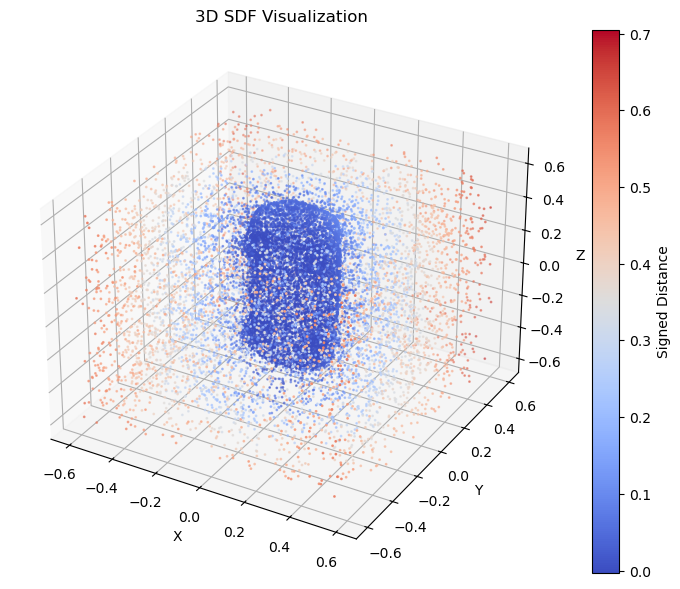

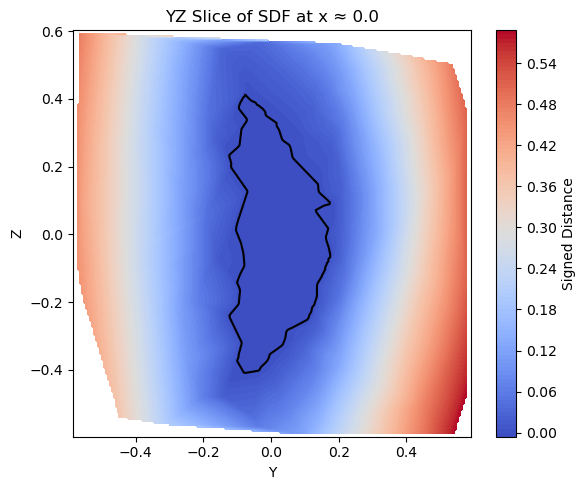

TRUTH


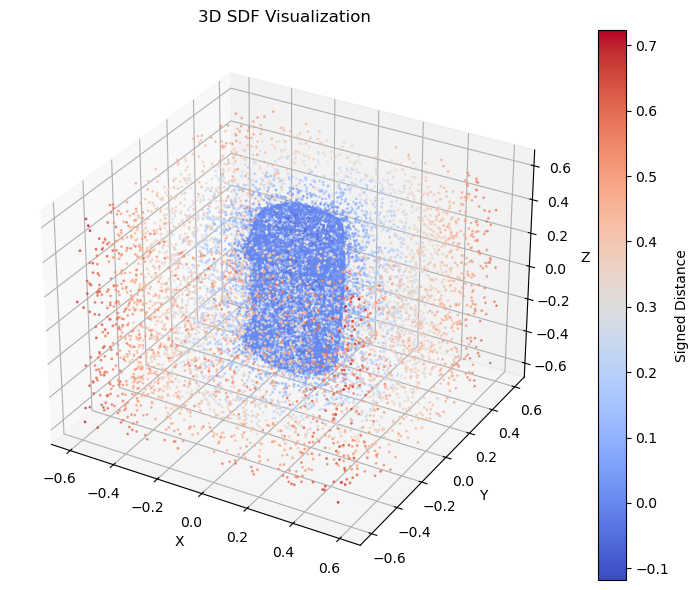

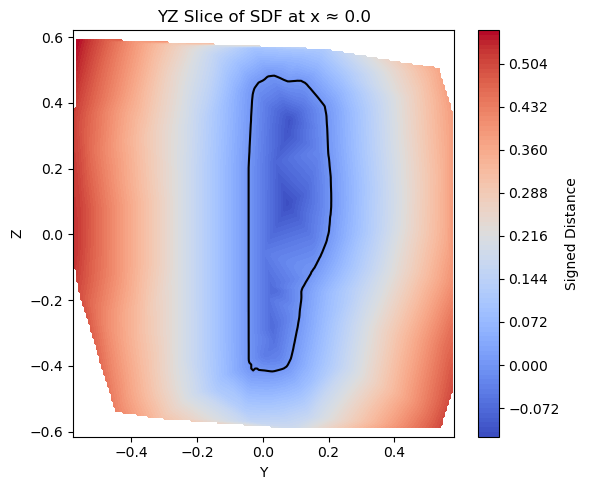


  1%|▏         | 20/1500 [06:20<7:58:47, 19.41s/it]

Validation Loss: 0.0033



  1%|▏         | 21/1500 [06:39<7:54:57, 19.27s/it]

Epoch   21 | Loss: 0.0019



  1%|▏         | 22/1500 [06:58<7:52:12, 19.17s/it]

Epoch   22 | Loss: 0.0021



  2%|▏         | 23/1500 [07:17<7:50:16, 19.10s/it]

Epoch   23 | Loss: 0.0015



  2%|▏         | 24/1500 [07:36<7:48:29, 19.04s/it]

Epoch   24 | Loss: 0.0020



  2%|▏         | 25/1500 [07:54<7:47:16, 19.01s/it]

Epoch   25 | Loss: 0.0009



  2%|▏         | 26/1500 [08:13<7:45:48, 18.96s/it]

Epoch   26 | Loss: 0.0055



  2%|▏         | 27/1500 [08:32<7:45:10, 18.95s/it]

Epoch   27 | Loss: 0.0010



  2%|▏         | 28/1500 [08:51<7:44:06, 18.92s/it]

Epoch   28 | Loss: 0.0022



  2%|▏         | 29/1500 [09:10<7:43:11, 18.89s/it]

Epoch   29 | Loss: 0.0009



  2%|▏         | 30/1500 [09:29<7:42:57, 18.90s/it]

Epoch   30 | Loss: 0.0011



  2%|▏         | 31/1500 [09:48<7:42:57, 18.91s/it]

Epoch   31 | Loss: 0.0024



  2%|▏         | 32/1500 [10:07<7:42:18, 18.90s/it]

Epoch   32 | Loss: 0.0014



  2%|▏         | 33/1500 [10:25<7:41:54, 18.89s/it]

Epoch   33 | Loss: 0.0019



  2%|▏         | 34/1500 [10:44<7:41:11, 18.88s/it]

Epoch   34 | Loss: 0.0022



  2%|▏         | 35/1500 [11:03<7:41:15, 18.89s/it]

Epoch   35 | Loss: 0.0014



  2%|▏         | 36/1500 [11:22<7:41:08, 18.90s/it]

Epoch   36 | Loss: 0.0033



  2%|▏         | 37/1500 [11:41<7:40:29, 18.89s/it]

Epoch   37 | Loss: 0.0013



  3%|▎         | 38/1500 [12:00<7:41:35, 18.94s/it]

Epoch   38 | Loss: 0.0016



  3%|▎         | 39/1500 [12:19<7:42:10, 18.98s/it]

Epoch   39 | Loss: 0.0018


Epoch   40 | Loss: 0.0019


MODEL


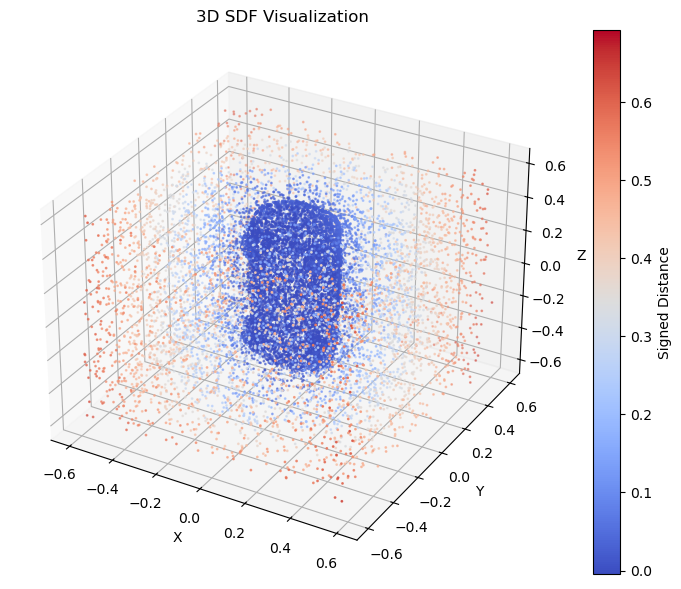

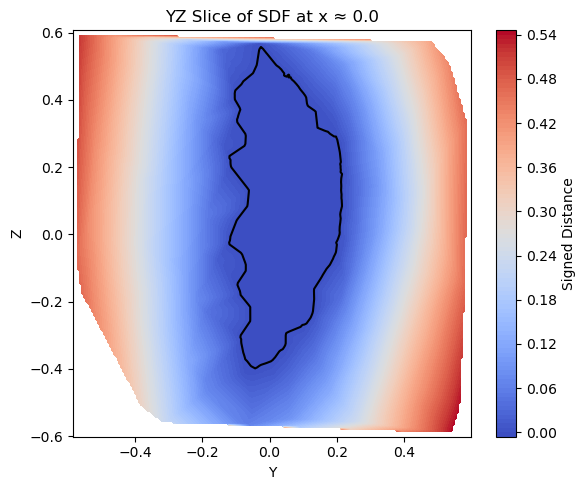

TRUTH


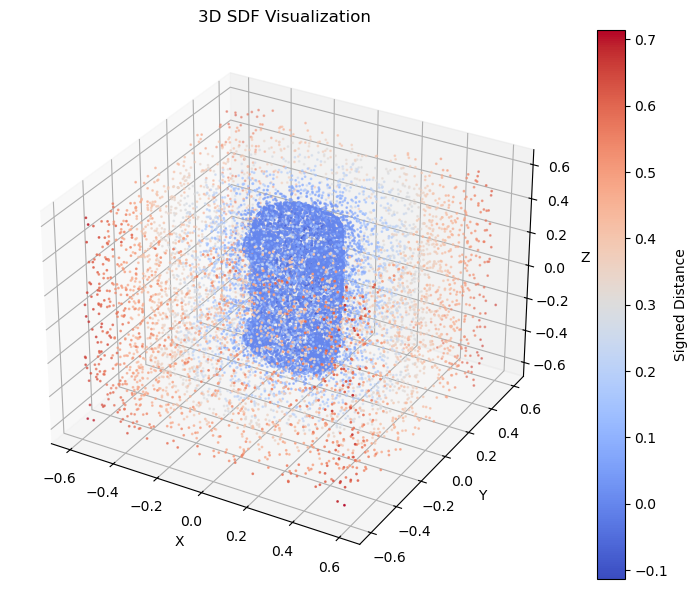

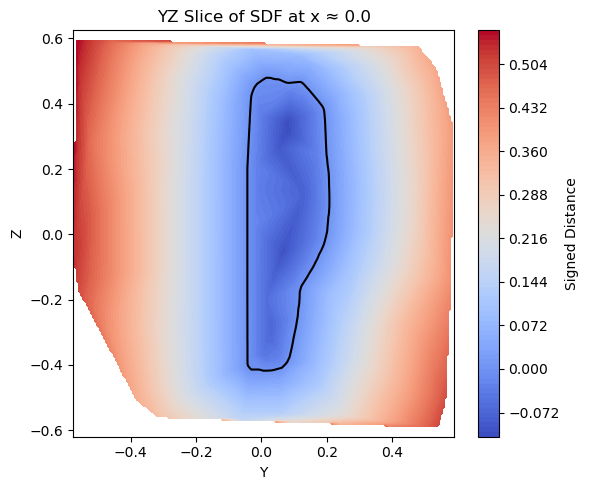


  3%|▎         | 40/1500 [12:40<7:53:46, 19.47s/it]

Validation Loss: 0.0011



  3%|▎         | 41/1500 [12:59<7:49:23, 19.30s/it]

Epoch   41 | Loss: 0.0028



  3%|▎         | 42/1500 [13:18<7:46:00, 19.18s/it]

Epoch   42 | Loss: 0.0010



  3%|▎         | 43/1500 [13:36<7:43:42, 19.10s/it]

Epoch   43 | Loss: 0.0016



  3%|▎         | 44/1500 [13:55<7:42:02, 19.04s/it]

Epoch   44 | Loss: 0.0015



  3%|▎         | 45/1500 [14:14<7:40:48, 19.00s/it]

Epoch   45 | Loss: 0.0019



  3%|▎         | 46/1500 [14:33<7:39:28, 18.96s/it]

Epoch   46 | Loss: 0.0018



  3%|▎         | 47/1500 [14:52<7:38:32, 18.93s/it]

Epoch   47 | Loss: 0.0035



  3%|▎         | 48/1500 [15:11<7:37:47, 18.92s/it]

Epoch   48 | Loss: 0.0016



  3%|▎         | 49/1500 [15:30<7:37:25, 18.91s/it]

Epoch   49 | Loss: 0.0018



  3%|▎         | 50/1500 [15:49<7:36:48, 18.90s/it]

Epoch   50 | Loss: 0.0042



  3%|▎         | 51/1500 [16:08<7:36:07, 18.89s/it]

Epoch   51 | Loss: 0.0011



  3%|▎         | 52/1500 [16:26<7:35:39, 18.88s/it]

Epoch   52 | Loss: 0.0013



  4%|▎         | 53/1500 [16:45<7:35:14, 18.88s/it]

Epoch   53 | Loss: 0.0008



  4%|▎         | 54/1500 [17:04<7:34:33, 18.86s/it]

Epoch   54 | Loss: 0.0010



  4%|▎         | 55/1500 [17:23<7:34:21, 18.87s/it]

Epoch   55 | Loss: 0.0010



  4%|▎         | 56/1500 [17:42<7:33:52, 18.86s/it]

Epoch   56 | Loss: 0.0010



  4%|▍         | 57/1500 [18:01<7:33:37, 18.86s/it]

Epoch   57 | Loss: 0.0082



  4%|▍         | 58/1500 [18:20<7:33:18, 18.86s/it]

Epoch   58 | Loss: 0.0021



  4%|▍         | 59/1500 [18:38<7:32:35, 18.84s/it]

Epoch   59 | Loss: 0.0012


Epoch   60 | Loss: 0.0027


MODEL


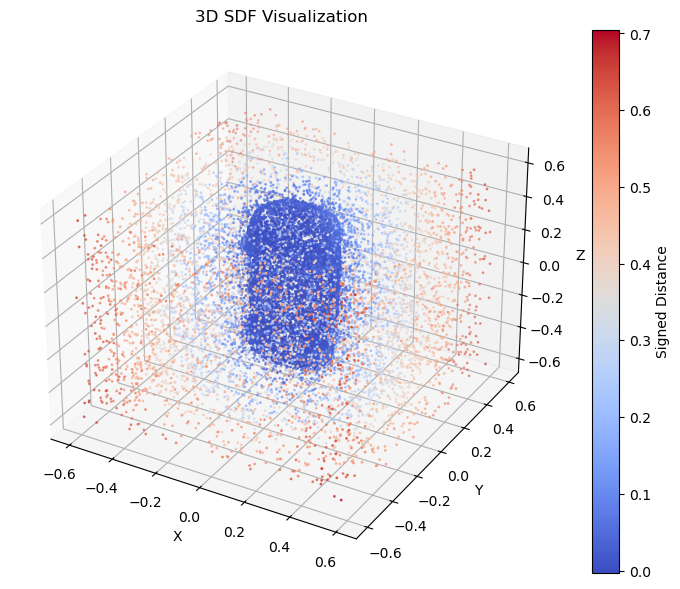

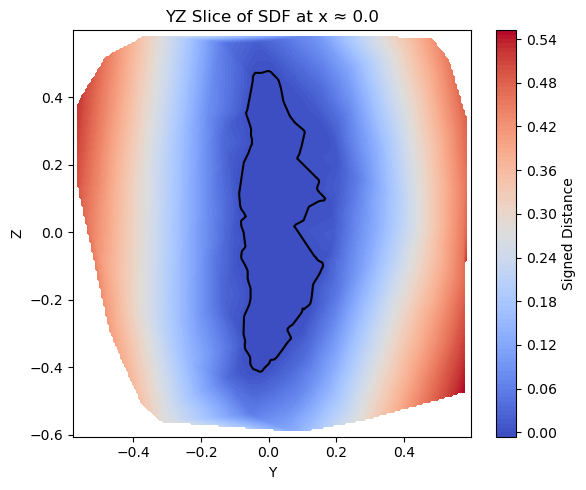

TRUTH


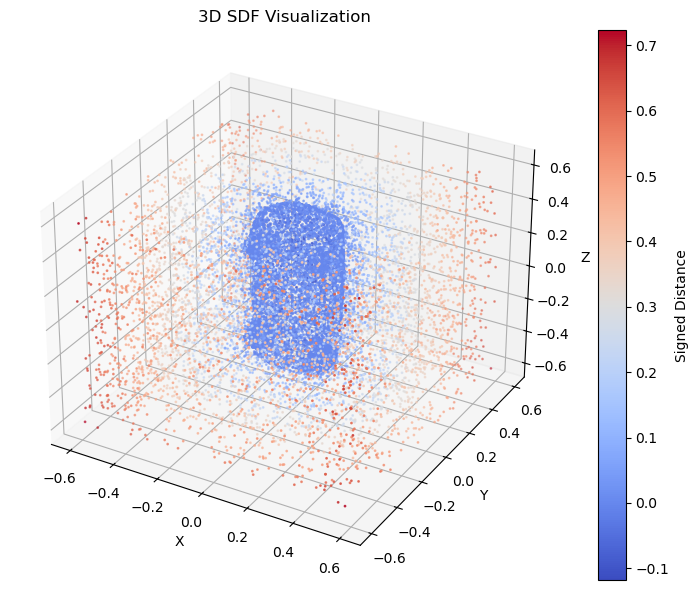

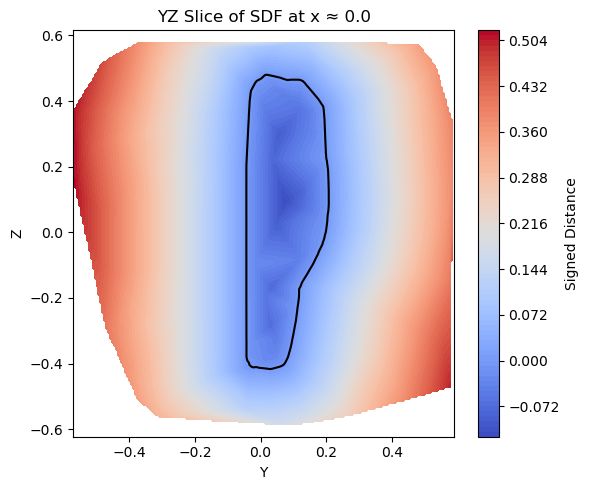


  4%|▍         | 60/1500 [18:59<7:42:50, 19.28s/it]

Validation Loss: 0.0027



  4%|▍         | 61/1500 [19:18<7:39:42, 19.17s/it]

Epoch   61 | Loss: 0.0012



  4%|▍         | 62/1500 [19:36<7:36:58, 19.07s/it]

Epoch   62 | Loss: 0.0014



  4%|▍         | 63/1500 [19:55<7:35:33, 19.02s/it]

Epoch   63 | Loss: 0.0009



  4%|▍         | 64/1500 [20:14<7:34:26, 18.99s/it]

Epoch   64 | Loss: 0.0020



  4%|▍         | 65/1500 [20:33<7:32:45, 18.93s/it]

Epoch   65 | Loss: 0.0010



  4%|▍         | 66/1500 [20:52<7:31:56, 18.91s/it]

Epoch   66 | Loss: 0.0008



  4%|▍         | 67/1500 [21:11<7:31:26, 18.90s/it]

Epoch   67 | Loss: 0.0017



  5%|▍         | 68/1500 [21:30<7:30:59, 18.90s/it]

Epoch   68 | Loss: 0.0019



  5%|▍         | 69/1500 [21:49<7:30:33, 18.89s/it]

Epoch   69 | Loss: 0.0017



  5%|▍         | 70/1500 [22:07<7:29:51, 18.88s/it]

Epoch   70 | Loss: 0.0016



  5%|▍         | 71/1500 [22:26<7:29:35, 18.88s/it]

Epoch   71 | Loss: 0.0013



  5%|▍         | 72/1500 [22:45<7:28:45, 18.86s/it]

Epoch   72 | Loss: 0.0008



  5%|▍         | 73/1500 [23:04<7:28:13, 18.85s/it]

Epoch   73 | Loss: 0.0013



  5%|▍         | 74/1500 [23:23<7:27:17, 18.82s/it]

Epoch   74 | Loss: 0.0010



  5%|▌         | 75/1500 [23:42<7:27:20, 18.84s/it]

Epoch   75 | Loss: 0.0015



  5%|▌         | 76/1500 [24:00<7:27:25, 18.85s/it]

Epoch   76 | Loss: 0.0007



  5%|▌         | 77/1500 [24:19<7:27:22, 18.86s/it]

Epoch   77 | Loss: 0.0069



  5%|▌         | 78/1500 [24:38<7:27:01, 18.86s/it]

Epoch   78 | Loss: 0.0245



  5%|▌         | 79/1500 [24:57<7:26:44, 18.86s/it]

Epoch   79 | Loss: 0.0009


Epoch   80 | Loss: 0.0010


MODEL


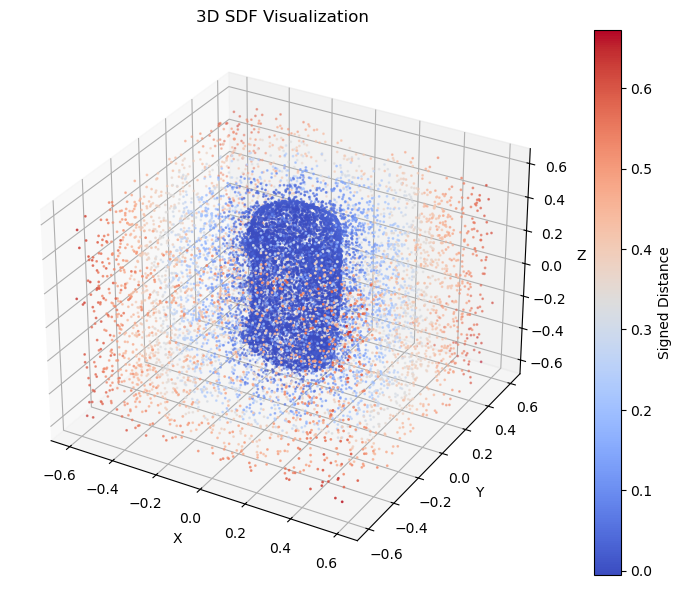

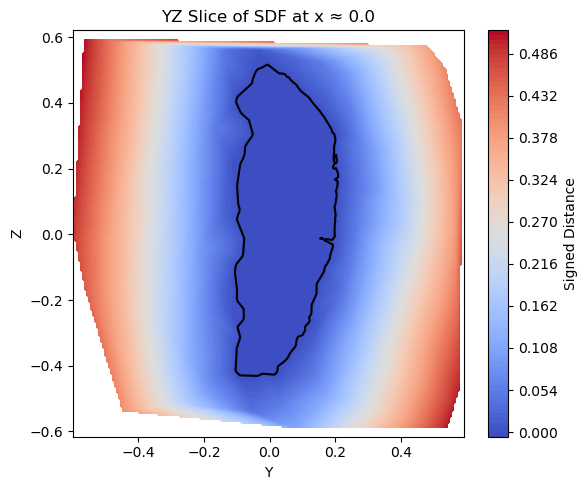

TRUTH


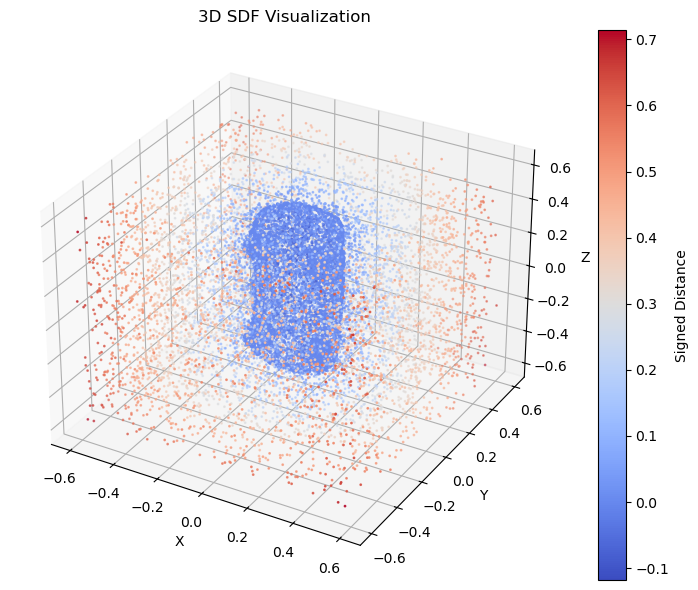

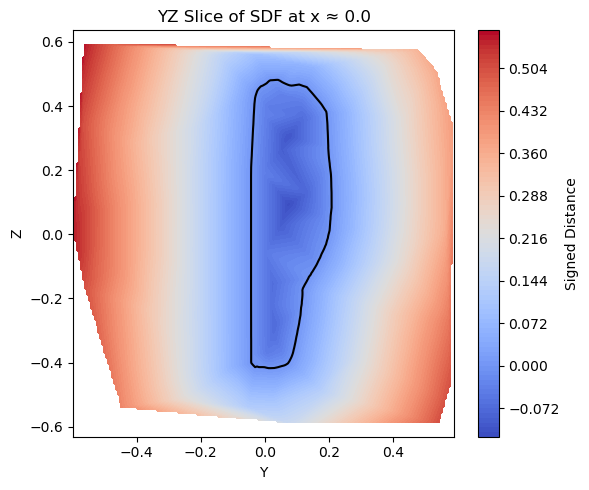


  5%|▌         | 80/1500 [25:17<7:37:26, 19.33s/it]

Validation Loss: 0.0008



  5%|▌         | 81/1500 [25:36<7:33:25, 19.17s/it]

Epoch   81 | Loss: 0.0011



  5%|▌         | 82/1500 [25:55<7:31:08, 19.09s/it]

Epoch   82 | Loss: 0.0016



  6%|▌         | 83/1500 [26:14<7:28:57, 19.01s/it]

Epoch   83 | Loss: 0.0011



  6%|▌         | 84/1500 [26:33<7:27:20, 18.96s/it]

Epoch   84 | Loss: 0.0010



  6%|▌         | 85/1500 [26:52<7:26:05, 18.92s/it]

Epoch   85 | Loss: 0.0016



  6%|▌         | 86/1500 [27:11<7:25:38, 18.91s/it]

Epoch   86 | Loss: 0.0009



  6%|▌         | 87/1500 [27:29<7:25:10, 18.90s/it]

Epoch   87 | Loss: 0.0011



  6%|▌         | 88/1500 [27:48<7:24:21, 18.88s/it]

Epoch   88 | Loss: 0.0014



  6%|▌         | 89/1500 [28:07<7:24:09, 18.89s/it]

Epoch   89 | Loss: 0.0033



  6%|▌         | 90/1500 [28:26<7:23:43, 18.88s/it]

Epoch   90 | Loss: 0.0017



  6%|▌         | 91/1500 [28:45<7:23:08, 18.87s/it]

Epoch   91 | Loss: 0.0009



  6%|▌         | 92/1500 [29:04<7:22:37, 18.86s/it]

In [ ]:
from tqdm import tqdm

EPOCHS = 1500

def train(epoch):
    model.train()
    total_loss = 0.0
    n_batches = 0   
    for batch in train_loader:
        x, pos, batch, query_pos, query_sdf = process_batch(batch)
        query_pos.requires_grad = True
        optimizer.zero_grad()
        out, mu, logvar = model(x, pos, batch, query_pos)
        loss = compute_loss(out.squeeze(-1), query_pos, query_sdf, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    
    mean_loss = total_loss / n_batches
    return mean_loss


log_path = 'loss_log_simple.txt'
with open(log_path, 'w') as f:
    f.write('epoch,train_loss\n')

    for epoch in tqdm(range(1, EPOCHS+1)):
        loss = train(epoch)                     

        # write to file
        f.write(f'{epoch},{loss:.4f}\n')
        f.flush()
        
        # 5) (Optional) console feedback every 20 epochs
        if epoch % 1 == 0:
            print(f'Epoch {epoch:4d} | Loss: {loss:.4f}')
        if epoch % 20 == 0:
            show_validation()
            torch.save(model.state_dict(), 'pointnet_vaesdf_simple.pth') # save model
